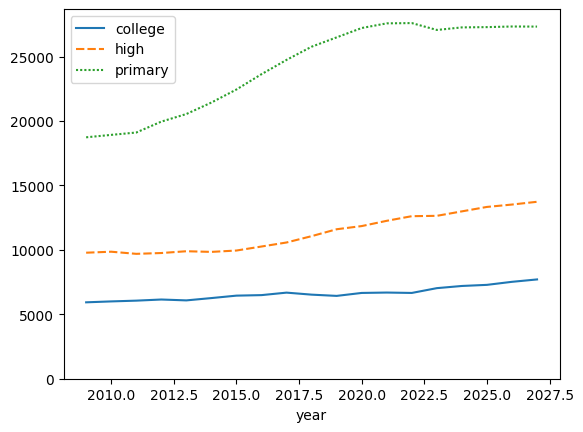

In [54]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

data = pd.read_csv("./school_projections.csv")

def year_sort(x):
    if x[-1].isalpha():
        if x == "kindergarten":
            return "primary"
        elif x == "mature":
            return "college"
    elif int(x[-2:].strip()) < 7:
        return "primary"
    elif int(x[-2:].strip()) < 11:
        return "high"
    else:
        return "college"

feed = pd.read_csv(
    "./Census_Data_for_all_ACT_Schools.csv",
    header=0,
    names=["census", "school", "category", "year", "students"],
    parse_dates=["census"]
)
feed.year = feed.year.str.lower()
feed = feed[
    (feed.category == "Gov") &
    (feed.year != "preschool") &
    (feed.census.dt.month == 2)
]
feed.census = feed.census.map(lambda x: f"year_{str(x.year)}")
feed.year = feed.year.map(year_sort)

feed = feed.groupby(["school", "year", "census"]).sum(numeric_only=True).reset_index()
feed.school = feed.school.map(
    lambda x: x.replace("Primary School", "Primary")
        .replace("High School", "High")
        .replace("Childhood School", "Childhood")
        .replace("University of Canberra", "UC")
        .replace("Secondary School", "Secondary")
        .replace("Cooperative School", "Cooperative")
        .replace("Canberra College, The", "The Canberra College")
        .replace("Senior Secondary College", "SSC")        
)

for i in feed.index:
    school = feed.at[i, "school"]
    school_type = feed.at[i, "year"]
    year = feed.at[i, "census"]
    value = feed.at[i, "students"]
    
    if school in data.school.map(lambda x: x.replace("*", "")).unique():
        search = data[
            (data.school.map(lambda x: x.replace("*", "") == school)) &
            (data.type == school_type)
        ]
        if len(search) == 1:
            index = search.index[0]
            data.at[index, year] = value

chart_data = feed.groupby(["census", "year"]).sum(numeric_only=True).reset_index()
cohorts = pd.DataFrame(columns=chart_data.year.unique())
cohorts.index.name = "year"
for i in chart_data.index:
    cohorts.at[int(chart_data.at[i, "census"][-4:]), chart_data.at[i, "year"]] = chart_data.at[i, "students"]

for year in range(2023, 2028):
    cohorts.loc[year] = [
        data[data.type == "college"][f"year_{year}"].sum(),
        data[data.type == "high"][f"year_{year}"].sum(),
        data[data.type == "primary"][f"year_{year}"].sum()
    ]

sns.lineplot(cohorts)
plt.ylim(0,)

cohorts.to_csv("./schoolCohorts.csv")
data.to_csv("./schoolProjections.csv")